In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import dateutil
from matplotlib import pyplot as plt
from creme import preprocessing

from online_ts import SARMA_OGD
from utils import mape, rmse

In [2]:
def create_date_col(row):
    """
    Tạo cột `date` cho dữ liệu load
    """
    date = dateutil.parser.parse(str(row['Timestamp'])).strftime('%m-%d-%Y')
    hour = str(row['Gio'])[1:].zfill(2)
    _datetime = f'{date} {hour}:00:00'
    return _datetime

def interpolate_nan_and_outlier(df, column):
    """
    Nội suy các dữ liệu thiếu và dữ liệu bất thường của cột trong dataframe
    """
    _df = df.copy()
    
    q75, q25 = np.nanpercentile(_df[column], [75, 25])
    iqr = q75 - q25
    
    _df[(_df[column] < q25 - 1.5 * iqr) | (_df[column] > q75 + 1.5 * iqr)] = np.nan # set nan for outliers
    _df[column] = _df[column].interpolate() # interpolate nan values
    return _df

def preprocess_load(df_load):
    hour_cols = [col for col in df_load.columns if col not in ['Timestamp']]
    df_load = pd.melt(df_load, id_vars=['Timestamp'], value_vars=hour_cols, var_name='Gio', value_name='Load')
    df_load['Date'] = df_load.apply(create_date_col, axis=1)
    df_load = df_load[['Date', 'Load']].copy()
    df_load['Date']= pd.to_datetime(df_load['Date'])
    df_load = df_load.sort_values(by='Date', ignore_index=True)
    df_load.set_index('Date', inplace=True)

    df_load = interpolate_nan_and_outlier(df_load, column='Load')
    df_load = df_load.resample('1H').mean().interpolate()
    return df_load

In [3]:
df = pd.read_csv('../data/Load_2021.csv')
df = preprocess_load(df)
actual = df['Load'][-696:]

In [6]:
pd.read_csv('../data/Load_2021.csv')

,Timestamp,H0,H1,H2,H3,H4,H5,H6,H7,H8,...,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23
0,2021-01-01,20243.630,19711.938,19599.077,19543.491,19649.902,19562.062,20674.950,20526.443,20284.050,...,20181.676,22061.078,23737.510,26174.624,23507.554,22554.414,21571.366,20132.398,18465.876,17423.869
1,2021-01-02,17041.711,16800.135,16697.893,17164.117,17999.727,19434.656,21993.124,24297.237,25000.379,...,26403.480,27799.891,28488.223,30149.097,27228.698,25834.388,25141.555,23506.907,21796.700,20893.608
2,2021-01-03,20266.189,20090.687,19820.371,20094.355,20373.084,21037.125,22985.614,24192.259,24310.685,...,26203.564,27594.005,29517.735,31310.413,28416.422,26872.442,25984.140,24262.565,22223.067,21322.247
3,2021-01-04,20858.764,20597.924,20583.662,20798.644,21738.629,23843.244,26607.812,29703.703,30534.599,...,32475.031,33331.266,34946.045,35641.907,32870.473,31328.736,29878.110,27653.494,26071.868,24046.635
4,2021-01-05,23343.600,23174.273,23106.104,23219.319,23865.169,25711.084,27646.402,30856.196,31759.866,...,33014.686,34074.221,34536.496,36090.126,32891.616,31394.150,30253.182,27864.918,26272.747,24356.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,2021-07-25,25414.440,24817.157,24131.759,23283.664,22677.520,22960.183,23260.886,24576.534,25525.725,...,27403.591,27846.502,27918.395,27654.350,28943.408,28242.935,27987.994,27511.301,26253.363,24840.883
206,2021-07-26,23735.566,22965.483,22496.500,22234.203,22259.857,23073.074,24865.375,28526.500,29632.191,...,33184.182,33513.284,31637.165,30440.997,31475.200,30924.099,31651.716,31258.783,29958.149,28129.299
207,2021-07-27,26812.621,26129.896,25405.953,24946.596,24881.437,25056.640,26396.284,30048.189,31386.613,...,34277.984,33245.887,31298.494,30357.966,31020.300,31069.757,32454.866,32458.983,31264.286,29595.916
208,2021-07-28,27987.387,27000.145,26229.478,25674.810,24896.552,25130.234,26453.205,29885.818,31215.771,...,34154.007,33472.057,30919.537,30130.296,30325.586,30064.987,30937.823,30546.947,29541.874,27933.646


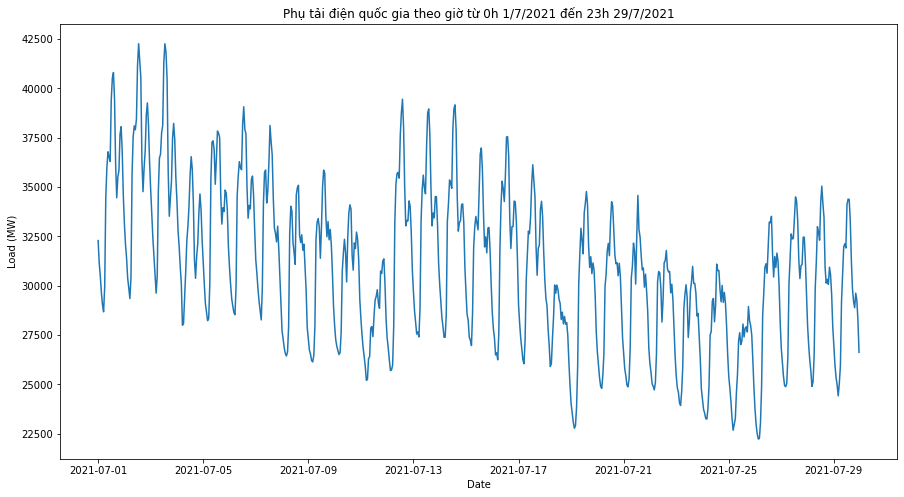

In [4]:
plt.figure(figsize=(15,8))
plt.plot(actual)
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.title('Phụ tải điện quốc gia theo giờ từ 0h 1/7/2021 đến 23h 29/7/2021')
plt.show()

In [5]:
def online_forecast(series, p, P, s):
    series_ = series.copy()
    series_ = np.log(series_)
    X_max = ((series_ - series_.mean()) / series_.std()).abs().max()
    model = SARMA_OGD(p, P, s, X_max)
    X_pred = []
    scaler = preprocessing.StandardScaler()
    
    for x in series_:
        # compute current mean and variance before normalizing to prevent data leakage
        current_std = scaler.vars['x'] ** 0.5
        current_mean = scaler.means['x']

        # normalize
        x = {'x': x}
        x_normalized = scaler.fit_one(x).transform_one(x)['x']

        # predict and fit model
        x_pred_normalized, loss = model.fit_one_step(x_normalized)

        # inverse transform
        x_pred = x_pred_normalized * current_std + current_mean

        X_pred.append(x_pred)
    
    forecast = np.exp(X_pred)
    return forecast

## Box plot

In [6]:
mapes_sarma = []
mapes_arma = []
rmses_sarma = []
rmses_arma = []
for _ in range(30):
    forecast_sarma = online_forecast(actual, p=2, P=2, s=24)
    forecast_arma = online_forecast(actual, p=2, P=0, s=24)
    
    mapes_sarma.append(100*mape(actual, forecast_sarma))
    mapes_arma.append(100*mape(actual, forecast_arma))
    rmses_sarma.append(rmse(actual, forecast_sarma))
    rmses_arma.append(rmse(actual, forecast_arma))

In [7]:
print("SARMA-OGD:")
print("Average MAPE: {}%".format(np.mean(mapes_sarma)))
print("Average RMSE: {}".format(np.mean(rmses_sarma)))
print("\n")
print("ARMA-OGD:")
print("Average MAPE: {}%".format(np.mean(mapes_arma)))
print("Average RMSE: {}".format(np.mean(rmses_arma)))

SARMA-OGD:
Average MAPE: 2.6354039126462%
Average RMSE: 1690.974342490131


ARMA-OGD:
Average MAPE: 3.6418436991311096%
Average RMSE: 1824.2996987567471


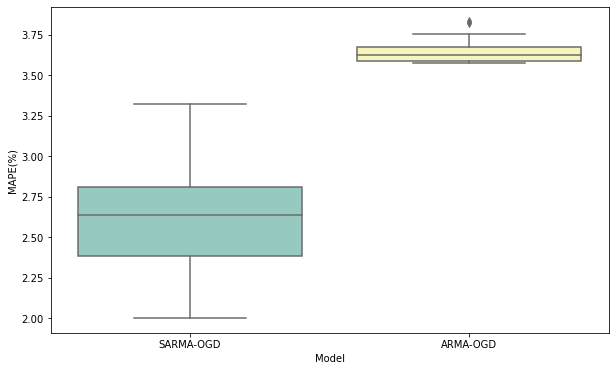

In [8]:
boxplot_mape_dict = {
    'Model': ['SARMA-OGD']*30 + ['ARMA-OGD']*30,
    'MAPE(%)': mapes_sarma + mapes_arma
}

boxplot_mape_df = pd.DataFrame.from_dict(boxplot_mape_dict)

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Model', y='MAPE(%)', data=boxplot_mape_df, palette='Set3')
plt.show()

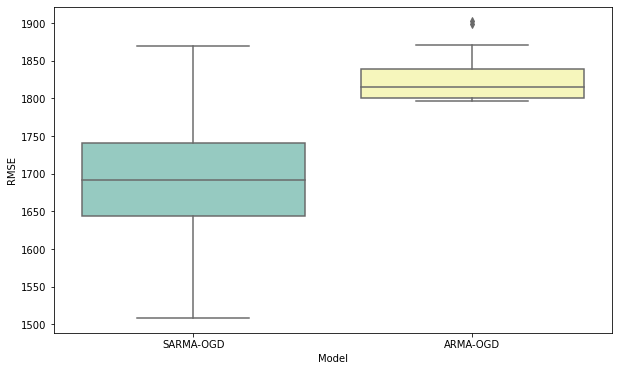

In [9]:
boxplot_rmse_dict = {
    'Model': ['SARMA-OGD']*30 + ['ARMA-OGD']*30,
    'RMSE': rmses_sarma + rmses_arma
}

boxplot_rmse_df = pd.DataFrame.from_dict(boxplot_rmse_dict)

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Model', y='RMSE', data=boxplot_rmse_df, palette='Set3')
plt.show()

## Forecast

In [10]:
forecast_sarma = online_forecast(actual, p=2, P=2, s=24)
forecast_arma = online_forecast(actual, p=2, P=0, s=24)

In [11]:
df_plot = actual.to_frame('actual')
df_plot['forecast_sarma'] = forecast_sarma
df_plot['forecast_arma'] = forecast_arma

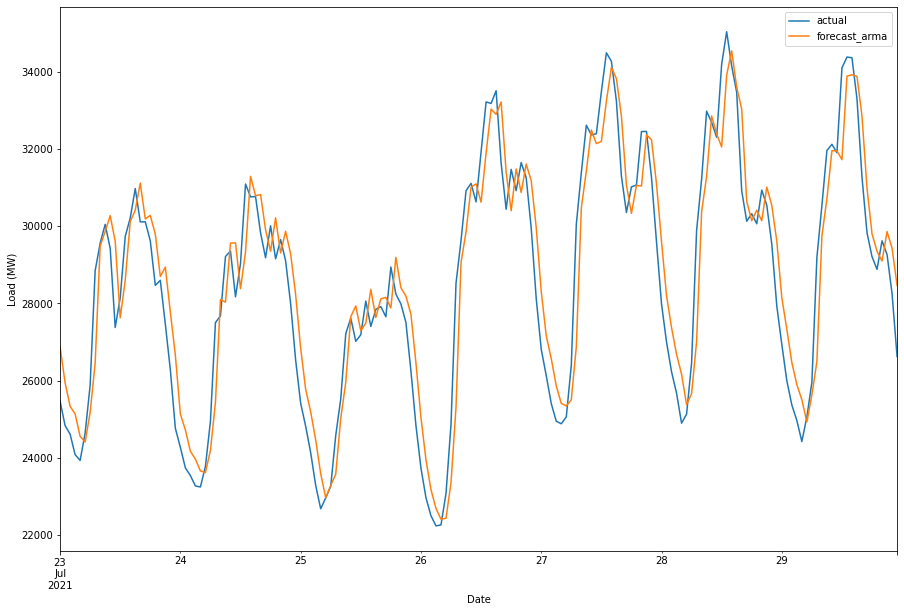

In [12]:
df_plot[['actual', 'forecast_arma']][-24*7:].plot(figsize=(15,10))
plt.ylabel('Load (MW)')
plt.show()

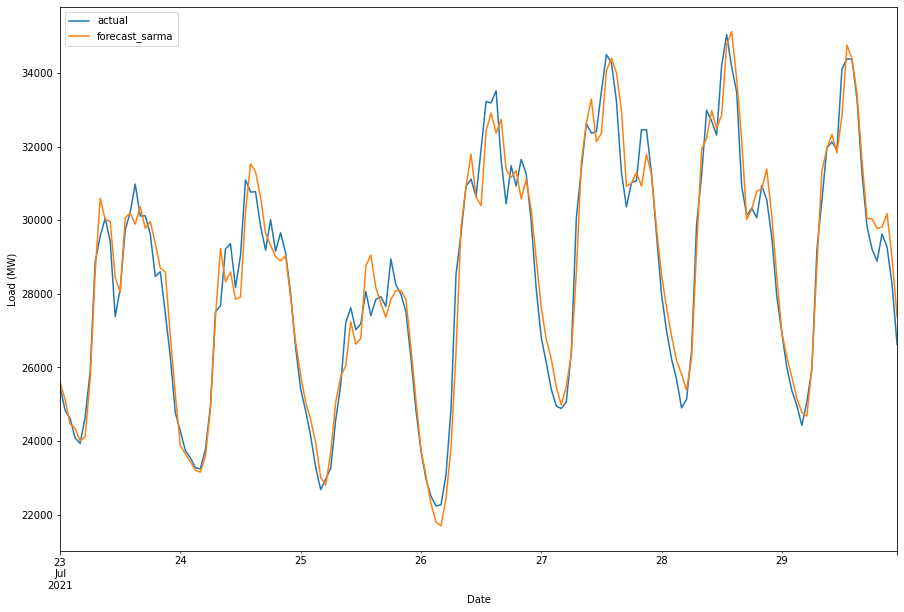

In [13]:
df_plot[['actual', 'forecast_sarma']][-24*7:].plot(figsize=(15,10))
plt.ylabel('Load (MW)')
plt.show()